# MCMC From Scratch
## Sebastian D. Goodfellow, Ph.D.

In [52]:
# Configure Notebook
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Import 3rd party libraries
import numpy as np
from scipy.stats import norm
import matplotlib.pylab as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Dummy Data Example

## Create Dummy Data

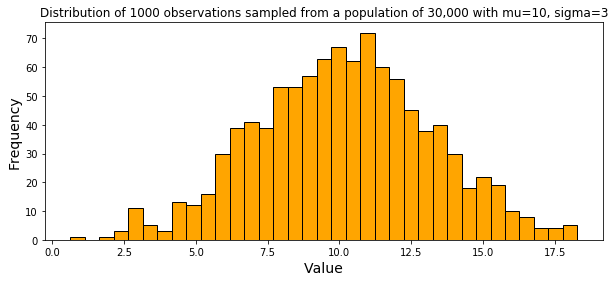

Observed Mean: 10.134776467781593


In [30]:
# Create sample population with nodel distribution (mean: 10, std: 3)
population = np.random.normal(10, 3, 30000)

# Assume we are only able to observe 1,000 of these individuals.
observation = population[np.random.randint(0, 30000, 1000)]

# Plot Observations
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(1, 1, 1)
ax.hist(observation,bins=35, color='orange', edgecolor='k')
ax.set_xlabel('Value', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14)
ax.set_title('Distribution of 1000 observations sampled from a population of 30,000 with mu=10, sigma=3')

plt.show()

print('Observed Mean: {}'.format(observation.mean()))

## Implementation

In [31]:
def transition_model(x):
    """
    The tranistion model defines how to move from sigma_current to sigma_new.
    """
    return [x[0], np.random.normal(x[1], 0.5, 1)[0]]

In [32]:
def prior(x):
    """
    x[0] = mu, x[1] = sigma (new or current)
    
    Returns 1 for all valid values of sigma. 
    Log(1) = 0, so it does not affect the summation.
    
    Returns 0 for all invalid values of sigma (<=0). 
    Log(0)=-infinity, and Log(negative number) is undefined.
    
    It makes the new sigma infinitely unlikely.
    """
    if x[1] <= 0:
        return 0
    else:
        return 1

In [33]:
def manual_log_likelihood_normal(x, data):
    """
    Computes the likelihood of the data given a sigma (new or current).
    
    x[0] = mu, x[1] = sigma (new or current)
    data = the observation
    """
    return np.sum(-np.log(x[1] * np.sqrt(2 * np.pi)) - 
                  ((data - x[0])**2) / (2 * x[1]**2))

In [34]:
def log_likelihood_normal(x, data):
    """
    Same as manual_log_likelihood_normal(x, data), but using scipy implementation #slow.
    x[0] = mu, x[1] = sigma (new or current)
    data = the observation
    """
    return np.sum(np.log(scipy.stats.norm(x[0], x[1]).pdf(data)))

In [35]:
def acceptance(x, x_new):
    """
    Defines whether to accept or reject the new sample.
    """
    if x_new > x:
        return True
    else:
        accept = np.random.uniform(0, 1)
        # Since we did a log likelihood, we need to exponentiate in order to compare to the random number.
        # less likely x_new are less likely to be accepted.
        return (accept < (np.exp(x_new - x)))

In [36]:
def metropolis_hastings(likelihood_computer, prior, transition_model, 
                        param_init, iterations, data, acceptance_rule):
    """
    likelihood_computer(x, data): returns the likelihood that these parameters generated the data.
    transition_model(x): a function that draws a sample from a symmetric distribution and returns it.
    param_init: a starting sample.
    iterations: number of accepted to generated.
    data: the data that we wish to model.
    acceptance_rule(x, x_new): decides whether to accept or reject the new sample.
    """
    x = param_init
    accepted = list()
    rejected = list()
    for i in range(iterations):
        x_new =  transition_model(x)    
        x_lik = likelihood_computer(x, data)
        x_new_lik = likelihood_computer(x_new, data) 
        if acceptance_rule(x_lik + np.log(prior(x)), x_new_lik + np.log(prior(x_new))):            
            x = x_new
            accepted.append([x_new[0], x_new[1], i])
        else:
            rejected.append([x_new[0], x_new[1], i])            
                
    return np.array(accepted), np.array(rejected)

## Run The Algorithm 

In [37]:
# Set MCMC iterations
iterations = 5000

# Run
accepted, rejected = metropolis_hastings(
    likelihood_computer=manual_log_likelihood_normal, 
    prior=prior, transition_model=transition_model,
    param_init=[observation.mean(), 0.1],
    iterations=iterations, data=observation, 
    acceptance_rule=acceptance
)

# Print output
print('Interations: {}\nAccepted: {}\nRejected: {}'.format(iterations, accepted.shape[0], rejected.shape[0]))

Interations: 5000
Accepted: 851
Rejected: 4149


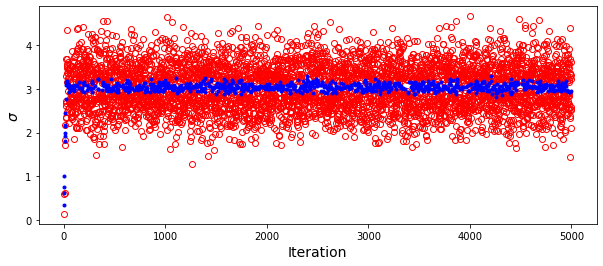

In [38]:
# Plot results
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(1, 1, 1)
ax.plot(rejected[:, 2], rejected[:, 1], 'o', markerfacecolor='none', markeredgecolor='r')
ax.plot(accepted[:, 2], accepted[:, 1], '.b')
ax.set_xlabel('Iteration', fontsize=14)
ax.set_ylabel('$\sigma$', fontsize=14)
plt.show()

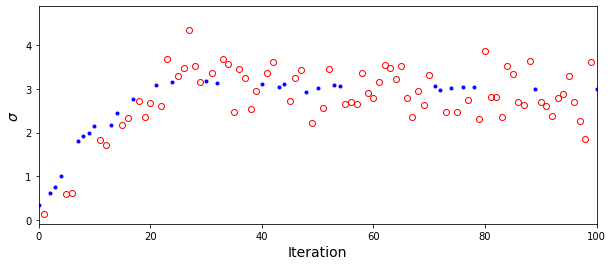

In [39]:
# Plot results
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(1, 1, 1)
ax.plot(rejected[:, 2], rejected[:, 1], 'o', markerfacecolor='none', markeredgecolor='r')
ax.plot(accepted[:, 2], accepted[:, 1], '.b')
ax.set_xlabel('Iteration', fontsize=14)
ax.set_ylabel('$\sigma$', fontsize=14)
ax.set_xlim([0, 100])
plt.show()

# Evaluate Results

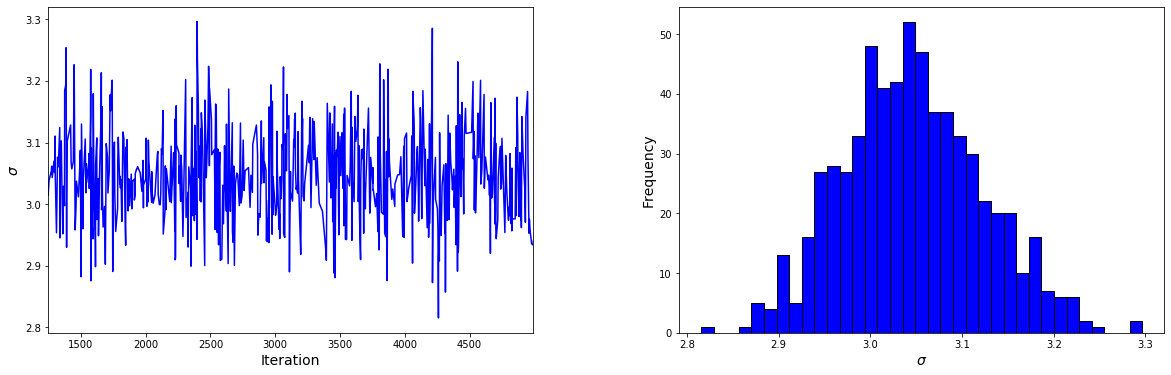

In [40]:
# Plot results
fig = plt.figure(figsize=(20, 6), facecolor='w')
fig.subplots_adjust(wspace=0.3, hspace=0)
ax1 = plt.subplot2grid((1, 2), (0, 0))
ax2 = plt.subplot2grid((1, 2), (0, 1))

ax1.plot(accepted[int(accepted.shape[0] * 0.25):, 2], accepted[int(accepted.shape[0] * 0.25):, 1], '-b')
ax1.set_xlabel('Iteration', fontsize=14)
ax1.set_ylabel('$\sigma$', fontsize=14)
ax1.set_xlim([accepted[int(accepted.shape[0] * 0.25), 2], accepted[accepted.shape[0]-1, 2]])

ax2.hist(accepted[int(accepted.shape[0] * 0.25):, 1], color='b', edgecolor='k', bins=35)
ax2.set_xlabel('$\sigma$', fontsize=14)
ax2.set_ylabel('Frequency', fontsize=14)

plt.show()

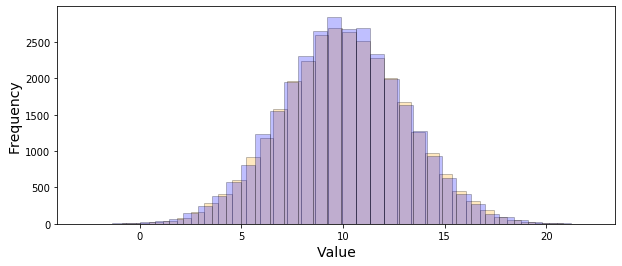

In [41]:
# Create sample population with nodel distribution (mean: 10, std: 3)
population = np.random.normal(10, 3, 30000)

# Assume we are only able to observe 1,000 of these individuals.
prediction = np.random.normal(10, np.mean(accepted[int(accepted.shape[0] * 0.25):, 1]), 30000)

# Plot Observations
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(1, 1, 1)
ax.hist(population, bins=35, color='orange', edgecolor='k', alpha=0.25)
ax.hist(prediction, bins=35, color='b', edgecolor='k', alpha=0.25)
ax.set_xlabel('Value', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14)

plt.show()

# 2. Real World Example

In [ ]:
scipy.

(array([ 4.,  1.,  2.,  2.,  0.,  4.,  2.,  7.,  5.,  6., 12., 14., 13.,
        10., 11., 24., 21., 32., 23., 32., 34., 47., 48., 62., 56., 60.,
        62., 63., 57., 67., 55., 64., 46., 29., 25.]),
 array([-5.77617825e+02, -5.61130887e+02, -5.44643949e+02, -5.28157010e+02,
        -5.11670072e+02, -4.95183133e+02, -4.78696195e+02, -4.62209257e+02,
        -4.45722318e+02, -4.29235380e+02, -4.12748442e+02, -3.96261503e+02,
        -3.79774565e+02, -3.63287627e+02, -3.46800688e+02, -3.30313750e+02,
        -3.13826812e+02, -2.97339873e+02, -2.80852935e+02, -2.64365996e+02,
        -2.47879058e+02, -2.31392120e+02, -2.14905181e+02, -1.98418243e+02,
        -1.81931305e+02, -1.65444366e+02, -1.48957428e+02, -1.32470490e+02,
        -1.15983551e+02, -9.94966128e+01, -8.30096745e+01, -6.65227361e+01,
        -5.00357978e+01, -3.35488594e+01, -1.70619210e+01, -5.74982677e-01]),
 <a list of 35 Patch objects>)

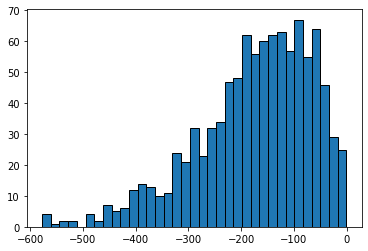

In [58]:
x = (1.3, 0.5)
data = observation


out = -np.log(x[1] * np.sqrt(2 * np.pi)) - ((data - x[0])**2) / (2 * x[1]**2)

plt.hist(out, 35, edgecolor='k')

(array([ 4.,  1.,  2.,  2.,  0.,  4.,  2.,  7.,  5.,  6., 12., 14., 13.,
        10., 11., 24., 21., 32., 23., 32., 34., 47., 48., 62., 56., 60.,
        62., 63., 57., 67., 55., 64., 46., 29., 25.]),
 array([-5.77617825e+02, -5.61130887e+02, -5.44643949e+02, -5.28157010e+02,
        -5.11670072e+02, -4.95183133e+02, -4.78696195e+02, -4.62209257e+02,
        -4.45722318e+02, -4.29235380e+02, -4.12748442e+02, -3.96261503e+02,
        -3.79774565e+02, -3.63287627e+02, -3.46800688e+02, -3.30313750e+02,
        -3.13826812e+02, -2.97339873e+02, -2.80852935e+02, -2.64365996e+02,
        -2.47879058e+02, -2.31392120e+02, -2.14905181e+02, -1.98418243e+02,
        -1.81931305e+02, -1.65444366e+02, -1.48957428e+02, -1.32470490e+02,
        -1.15983551e+02, -9.94966128e+01, -8.30096745e+01, -6.65227361e+01,
        -5.00357978e+01, -3.35488594e+01, -1.70619210e+01, -5.74982677e-01]),
 <a list of 35 Patch objects>)

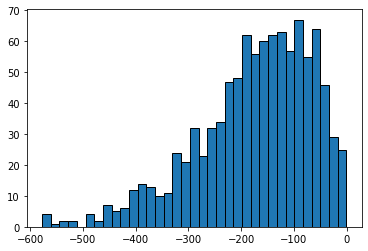

In [59]:
plt.hist(scipy.stats.norm(x[0], x[1]).logpdf(data), 35, edgecolor='k')